In [1]:
from diskcache_class import db
from lda_mallet import *
from pre_processing import *
from os import walk
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /home/amh418/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amh418/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/amh418/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amh418/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
#we are going to run this on 4 different dataset 1. EDML 2. AP 3. Newsgroup 4.Covid-Tweet


############################## reading data for ED corpus
datafolder = './data/ed_recovery_formatted/Excel'
#datafolder = 'ed_recovery_topicmodel'
df = pd.DataFrame(columns=['url','type','photo','date','tags','notes','text','photo_url','reblogged','blog_name'])

for dirpath,dirnames,filenames in walk(datafolder):
  for filename in filenames:
    if filename.endswith('.xlsx'):
      t = pd.read_excel(datafolder+'/'+filename,names=['url','type','photo','date','tags','notes','text','photo_url','reblogged'],engine='openpyxl')
      blog_name = t.iloc[0,0].split(':')[1]
      t['blog_name'] = blog_name
      df = df.append(t.iloc[3:,:],ignore_index=True)
      print('blog:{0}   with posts:{1}    and reblogs:{2}  '.format(filename,len(t),len(t[t.reblogged=='yes'])))


print('number of blogs: {0} - number of posts: {1}'.format(len(set(df.blog_name)),len(df)))
print('out of {0} documents, {1} are reblogged.'.format(len(df),len(df[df.reblogged == 'yes'])))

#finding reblogged texts
texts = sorted(df.text) #sort them to keep smallest post (perhaps original one) at first
re_texts = []

while len(texts):
  t = [texts.pop(0)]#pop first text and find it!
  if t[0] == ' ' or len(t[0].split())<3: 
    continue #almost nothing to look
  i = 0
  while i<len(texts):
    if t[0] in texts[i]:
      t.append(texts.pop(i))
    else:
      i += 1
  if len(t) > 1:
    re_texts.append(t)


print('number of unique reblogged texts: {0}'.format(len(re_texts)))
print('number of unique string in all texts: {0}'.format(len(set(df.text))))

extra_stopwords = ['isnt','want','cant','wanna','im','could','ive','would','dont','get','also','us','thats','got','ur','wanted',
                   'may', 'the', 'just', 'can', 'think', 'damn', 'still', 'guys', 'literally', 'hopefully', 'much', 'even', 'rly', 'guess', 'anon']#anything with a length of one
                   

'''pre-processing'''
# original_doc_set = list(df.text[df.photo=='no'])
sel_df = df[df.photo=='no'] #extracting only-text posts
doc_list = list(sel_df.text)


# ##############reading AP corpus
# text_df = ap_corpus('./data/ap.txt')
# doc_list = list(text_df.text_cleaned)

##############reading Newsgroup corpus
# text_df = newsgroup('./data/20newsgroup_preprocessed.csv')
# doc_list = list(text_df.text_cleaned)

##############Covid Tweet corpus
# doc_list=[]
# with open('./data/covid_tweets','r',encoding='utf-8') as txtfile:
#     doc_list = txtfile.readlines()


#loading ref corpus for coherene score for lda_mallet
wiki_docs = loading_wiki_docs('./data/wiki_sampled_10p.txt')
#doing pre-processing on wiki-pedia documents
pre_processed_wiki, _ = preprocess_data(wiki_docs)
wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)
del wiki_docs

blog:ariessuntaurusrising_formatted.xlsx   with posts:504    and reblogs:206  
blog:bagelbells_formatted.xlsx   with posts:1101    and reblogs:1046  
blog:brittle-bunny_formatted.xlsx   with posts:121    and reblogs:20  
blog:faithhopeloveandtherapy_formatted.xlsx   with posts:2994    and reblogs:1510  
blog:fearless-foodie_formatted.xlsx   with posts:3956    and reblogs:3670  
blog:finallyrecoveringforgood_formatted.xlsx   with posts:137    and reblogs:49  
blog:fuck-eatingdisorders_formatted.xlsx   with posts:37    and reblogs:4  
blog:hellsite-residential_formatted.xlsx   with posts:247    and reblogs:191  
blog:imtrying-butimpissed_formatted.xlsx   with posts:838    and reblogs:483  
blog:intentandotrascender_formatted.xlsx   with posts:21    and reblogs:0  
blog:lets-get-better_formatted.xlsx   with posts:509    and reblogs:453  
blog:matchayogurt_formatted.xlsx   with posts:219    and reblogs:168  
blog:mirithebrave_formatted.xlsx   with posts:578    and reblogs:299  
blog:mote-o

In [5]:
#removing terms that are not in Wikipedia ref-corpus
pre_processed_docs,filtered_docs = preprocess_data(doc_list,extra_stopwords={})
#generate vocabulary and texts
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)

#finding stopwords that are not in Wikipedia and removing those
extra_stopwords = set(vocab_dict.token2id.keys()).difference(set(wiki_vocab_dict.token2id.keys()))
pre_processed_docs,filtered_docs = preprocess_data(doc_list,extra_stopwords=extra_stopwords)
vocab_dict, doc_term_matrix = prepare_corpus(pre_processed_docs)

In [7]:
#running many many LDA and storing their pair of terms
import numpy as np

start = 6; limit=13; step = 1
runs = 3
num_permutation = 100
iterations = 5000
term_pairs = set()

for num_topics in tqdm(range(start, limit+1, step)):
    model_t = []
    purity_t = []
    coherence_t = []
    contrast_t = []
    for iter in np.random.permutation(iterations).tolist()[0:num_permutation]:
        #model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model = LdaMallet(mallet_path, corpus=doc_term_matrix, num_topics=num_topics, id2word=vocab_dict,optimize_interval = 25,workers=1, iterations=iter)

        #storing top_terms
        for tn in range(num_topics): 
            tt = model.show_topic(tn,topn=20)

            #saving top_terms and their counts
            top_terms = [i[0] for i in tt]

            #making pair terms
            for i in range(len(top_terms)):
                for j in range(i+1,len(top_terms)):
                    term_pairs.add((top_terms[i],top_terms[j]))
    

100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [8:53:50<00:00, 4003.83s/it]


In [8]:
#converting set to list
term_pairs_ls = [[i[0],i[1]] for i in list(term_pairs)]

In [9]:
#computing Coherence for all term pairs
cscore = CoherenceModel(topics=term_pairs,dictionary=wiki_vocab_dict,texts=pre_processed_wiki,coherence='c_npmi',processes=3,topn=2).get_coherence_per_topic()


In [10]:
#Loading the DB
npmi_db = db('./db/wiki_10p')

Load NPMI coherence DB. 
Number of keys : 187837


In [11]:
#writing into the DB
for i in tqdm(range(len(term_pairs_ls))):
    #if the key does not exist, insert it
    try:
        npmi_db.db[(term_pairs_ls[i][0],term_pairs_ls[i][1])]
    except:
        npmi_db.db[(term_pairs_ls[i][0],term_pairs_ls[i][1])] = cscore[i]
    #do the other combination
#     try:
#         npmi_db.db[(term_pairs_ls[i][1],term_pairs_ls[i][0])]
#     except:
#         npmi_db.db[(term_pairs_ls[i][1],term_pairs_ls[i][0])] = cscore[i]

100%|██████████████████████████████████████████████████████████████████████████| 42554/42554 [00:13<00:00, 3193.25it/s]


# Generating new NPMIs for a new corpus

In [5]:
old_db = db('./db/wiki_10p')
new_db = db('./db/wiki_full')

Load NPMI coherence DB. 
Number of keys : 219025
Load NPMI coherence DB. 
Number of keys : 204257


In [2]:
#loading ref corpus for coherene score for lda_mallet
#abs_path = 'G:\wiki_corpus_gensim\wiki20p0'
abs_path = '/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full'
wiki_docs = loading_wiki_docs(abs_path)
#doing pre-processing on wiki-pedia documents
pre_processed_wiki, _ = preprocess_data(wiki_docs)
wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)
del wiki_docs

In [4]:
term_pairs = set()
max_ins = 60000
count = 0

for k in old_db.db.iterkeys():
    #check if it is already in the list but in reverse order + if it is in the vocab
    if (k[1],k[0]) not in term_pairs and k[0] in wiki_vocab_dict.token2id.keys() and k[1] in wiki_vocab_dict.token2id.keys():
        #check if it is not in the new db as well
        try:
            new_db.db((k[0],k[1]))
        except:#only add if it is not in the db in the reverse order
            term_pairs.add((k[0],k[1]))
            count +=1
    #compute Gensim and insert into db
    if count>=max_ins:
        count = 0
        #compute coherence
        term_pairs_ls = [[i[0],i[1]] for i in list(term_pairs)]
        cscore = CoherenceModel(topics=term_pairs,dictionary=wiki_vocab_dict,texts=pre_processed_wiki,coherence='c_npmi',processes=6,topn=2).get_coherence_per_topic()
        #inseert into db
        for i in tqdm(range(len(term_pairs_ls))):
            #if the key does not exist, insert it
            try:
                skeys = sorted(term_pairs_ls[i])
                new_db.db[(skeys[0],skeys[1])]
            except:
                new_db.db[(skeys[0],skeys[1])] = cscore[i]
        print('inserted {0} NPMI into database'.format(max_ins))
        term_pairs = set()
        
        
if count>0:
    term_pairs_ls = [[i[0],i[1]] for i in list(term_pairs)]
    cscore = CoherenceModel(topics=term_pairs,dictionary=wiki_vocab_dict,texts=pre_processed_wiki,coherence='c_npmi',processes=3,topn=2).get_coherence_per_topic()
    #inseert into db
    for i in tqdm(range(len(term_pairs_ls))):
        #if the key does not exist, insert it
        try:
            skeys = sorted(term_pairs_ls[i])
            new_db.db[(skeys[0],skeys[1])]
        except:
            new_db.db[(skeys[0],skeys[1])] = cscore[i]
    print('inserted {0} remaining NPMI into database'.format(count))

100%|██████████| 60000/60000 [00:50<00:00, 1188.12it/s]


inserted 60000 NPMI into database


100%|██████████| 60000/60000 [00:47<00:00, 1252.76it/s]


inserted 60000 NPMI into database


100%|██████████| 60000/60000 [03:57<00:00, 252.33it/s]


inserted 60000 NPMI into database


100%|██████████| 26453/26453 [01:45<00:00, 250.04it/s]

inserted 26453 remaining NPMI into database


In [14]:
import pandas as pd


db_names = ['5p_old','10p','full']

#old_db = db('./db/wiki_10p')
full_db = db('./db/wiki_full')

keys = [i for i in full_db.db.iterkeys()]
df = pd.DataFrame(data=np.zeros((len(keys),3)),columns=db_names)
df.index = keys

df


Load NPMI coherence DB. 
Number of keys : 204257


,5p_old,10p,full
"(ac, au)",0.0,0.0,0.0
"(ac, ca)",0.0,0.0,0.0
"(ac, cc)",0.0,0.0,0.0
"(ac, ch)",0.0,0.0,0.0
"(ac, cs)",0.0,0.0,0.0
...,...,...,...
"(cryptocurrency, investigation)",0.0,0.0,0.0
"(czechoslovakia, environmental)",0.0,0.0,0.0
"(demonstrations, demonstrators)",0.0,0.0,0.0
"(hospitalization, transmission)",0.0,0.0,0.0


In [15]:
for n in db_names:
    wiki_db = db('./db/wiki_'+n)
    
    for k1,k2 in tqdm(wiki_db.db.iterkeys()):
        df.loc[df.index==(k1,k2),n] = wiki_db.db.get((k1,k2))

Load NPMI coherence DB. 
Number of keys : 364450


364450it [1:52:49, 53.84it/s]


Load NPMI coherence DB. 
Number of keys : 219025


219025it [1:08:15, 53.48it/s]


Load NPMI coherence DB. 
Number of keys : 204257


204257it [1:03:45, 53.40it/s]


/share/Apps/anaconda3/2020.07/envs/nlp/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


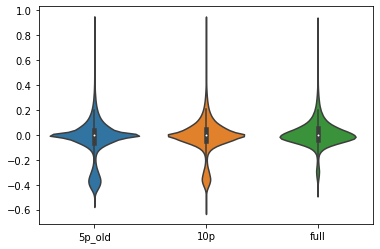

In [42]:
import seaborn as sns


ax = sns.violinplot(data=df)

fig = ax.get_figure()
fig.savefig('./result/wiki_subsample_NPMI_dist.png')


In [31]:
np.median(df.values,axis=0),np.mean(df.values,axis=0),np.std(df.values,axis=0)

(array([0.        , 0.        , 0.00081457]),
 array([-0.03693254, -0.01503386,  0.00908867]),
 array([0.15945738, 0.13877309, 0.1024672 ]))

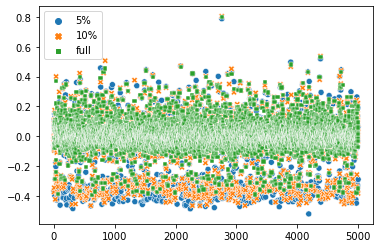

In [43]:
ax = sns.scatterplot(data=df.iloc[np.random.permutation(len(df))[0:5000],:].values)
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['5%', '10%','full'])

fig = ax.get_figure()
fig.savefig('./result/wiki_subsample_NPMI_scatter.png')

In [44]:
# wiki_db_10 = db('./db/wiki_10p')
# wiki_db_full = db('./db/wiki_full')

# diffs = set(wiki_db_10.db.iterkeys()).difference(set(wiki_db_full.db.iterkeys()))

Load NPMI coherence DB. 
Number of keys : 219025
Load NPMI coherence DB. 
Number of keys : 204257


In [56]:
# keys_to_insert = []
# for d in diffs:
#     if wiki_db_full.get(d) < -1.00:
#         keys_to_insert.append(d)

# adding list of words to a DB

In [8]:
wiki_db = db('./db/wiki_full')

Load NPMI coherence DB. 
Number of keys : 871181


In [3]:
#reading list of top-terms
all_top_terms = []

with open('./top_terms_iter_analysis.txt','r',encoding='utf-8') as txtfile:
    all_top_terms = txtfile.readlines()
    
len(all_top_terms)

470261

In [4]:
cand_top_terms = set()

for topic in all_top_terms:
    pairs = term_pairs_generator(topic.strip().split(','))
    for p1,p2 in pairs:
        skey = sorted([p1,p2])
        cand_top_terms.add((skey[0],skey[1])) 
            
len(cand_top_terms)

1055464

In [9]:
final_cand_top_terms = set()

for p1,p2 in cand_top_terms:
    #no key in the db
    if wiki_db.get((p1,p2)) == -100:
        final_cand_top_terms.add((p1,p2))
            
len(final_cand_top_terms)

833277

In [6]:
# #loading ref corpus for coherene score for lda_mallet
# #abs_path = 'G:\wiki_corpus_gensim\wiki20p0'
# abs_path = '/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full'
# wiki_docs = loading_wiki_docs(abs_path)
# #doing pre-processing on wiki-pedia documents
# pre_processed_wiki, _ = preprocess_data(wiki_docs)
# wiki_vocab_dict, _ = prepare_corpus(pre_processed_wiki)
# del wiki_docs

In [14]:
# import pickle

###write 
# with open('/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full_pre_processed_docs.list','wb') as objfile:
#     pickle.dump(pre_processed_wiki,objfile)
    
# with open('/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full_vocab.obj','wb') as objfile:
#     pickle.dump(wiki_vocab_dict,objfile)

In [10]:
import pickle

##Read
with open('/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full_pre_processed_docs.list','rb') as objfile:
    pre_processed_wiki = pickle.load(objfile)
    
with open('/home/amh418/erb416_proj/amh418/wiki_corpus/wiki_full_vocab.obj','rb') as objfile:
    wiki_vocab_dict = pickle.load(objfile)

In [11]:
cscore = CoherenceModel(topics=[[i[0],i[1]] for i in final_cand_top_terms if i[0] in wiki_vocab_dict.token2id and i[1] in wiki_vocab_dict.token2id],dictionary=wiki_vocab_dict,texts=pre_processed_wiki,coherence='c_npmi',processes=15,topn=2).get_coherence_per_topic()

In [13]:
pairs_to_add = [(i[0],i[1]) for i in final_cand_top_terms if i[0] in wiki_vocab_dict.token2id and i[1] in wiki_vocab_dict.token2id]
for i in tqdm(range(len(pairs_to_add))):
    wiki_db.db[list(pairs_to_add)[i]] = cscore[i]

100%|██████████| 833277/833277 [3:58:37<00:00, 58.20it/s]   
